![terrainbento logo](../images/terrainbento_logo.png)


# Introduction to the terrainbento `OutputWriters`.


## Overview
This tutorials shows example usage of the terrainbento boundary handlers. For comprehensive information about all options and defaults, refer to the [documentation](http://terrainbento.readthedocs.io/en/latest/). 

## Prerequisites
This tutorial assumes you have at least skimmed the [terrainbento manuscript]() and worked through the [Introduction to terrainbento]() tutorial. 


### terrainbento `OutputWriters`



### Example Usage

To begin, we will import the required python modules. 

In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from landlab.components import DrainageDensity
from landlab import imshow_grid

from terrainbento import Basic

In [2]:
def write_drainage_density(model):
    channels = model.grid.at_node['drainage_area'] > 2000
    dd = DrainageDensity(model.grid, channel__mask=channels)
    mean_drainage_density = dd.calc_drainage_density()    
    with open('drainage_density.' + str(int(model.model_time)) + '.txt', 'w') as f:
        f.write(str(mean_drainage_density))
    del dd


In [3]:
basic_params = {# these three parameters are required by all models
          'dt' : 500, # years
          'output_interval': 1e3, # years
          'run_duration': 2e5, # years
          # these parameters are needed to specify the details of the model 
          # grid, by default a raster model grid is created
          'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0, # meters  
          "add_random_noise": True, 
          "initial_noise_std": 1.,
          "initial_elevation": 5.,
          'random_seed': 4897, # set to initialize the topography with reproducible random noise
          # these parameter control geomorphic processes
          'water_erodability' : 0.001, # years^-1
          'm_sp' : 0.5, # unitless
          'n_sp' : 1.0, # unitless
          'regolith_transport_parameter' : 0.1, # meters^2/year
          # these parameters control model boundary conditions
          "BoundaryHandlers": "NotCoreNodeBaselevelHandler",
          "NotCoreNodeBaselevelHandler": {"modify_core_nodes": True, "lowering_rate": -0.0005} , # meters/year
          # these parameter control how model output is written
          'save_first_timestep': True,
          'output_filename': 'example_output_writer',
         }

In [4]:
basic = Basic(params=basic_params, OutputWriters=write_drainage_density)
basic.run(output_fields='topographic__elevation')

/Users/barnhark/projects/landlab/landlab/landlab/components/drainage_density/drainage_density.py:180: UserWarning: Existing channel__mask grid field was overwritten.
  warn("Existing channel__mask grid field was overwritten.")


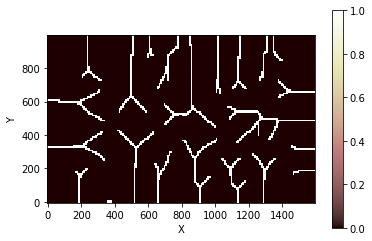

In [5]:
channels = basic.grid.at_node['drainage_area'] > 2000
imshow_grid(basic.grid, channels)

In [6]:
output_files = glob.glob('drainage_density.*.txt')
temp = {}
for of in output_files:
    with open(of, 'r') as f:
        model_time = int(of.split('.')[-2])
        drainage_density = float(f.readline())
        temp[model_time] = {'drainage_density': drainage_density}
    os.remove(of)
df = pd.DataFrame(temp).T

basic.remove_output_netcdfs()

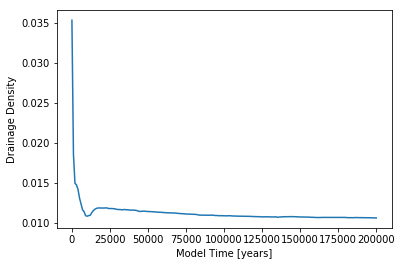

In [7]:
plt.figure()
plt.plot(df.index, df.drainage_density)
plt.xlabel('Model Time [years]')
plt.ylabel('Drainage Density')
plt.show()

In [8]:
class my_ouput_writer_class(object):
    def __init__(self, model):
        # save the model to the output writer class
        self.model = model
        # do whatever else you want to do here:
    def run_one_step(self):
        # make calculations
        
        # write something out based on the calculations. 
        # we recommend including the model time as a part of
        # the filename so that it is possible to identify
        # what time each file is associated with
        
        pass # remove this line when you modify this example. 
        

In [9]:
class time_averaged_elevation(object):
    def __init__(self, model):
        self.model = model
        self.model_time = []
        self.model_mean_elevation = []
        self.model_max_elevation = []
    def run_one_step(self):
        self.model_time.append(self.model.model_time)
        self.model_mean_elevation.append(self.model.z[self.model.grid.core_nodes].mean())
        self.model_max_elevation.append(self.model.z[self.model.grid.core_nodes].max())
        if len(self.model_time)>=5:
            with open('time_averaged_elevation.' + str(int(self.model.model_time)) + '.txt', 'w') as f:
                f.write(str(np.mean(self.model_mean_elevation[-5:])) + '\n')
                f.write(str(np.mean(self.model_max_elevation[-5:])) + '\n')

In [10]:
basic = Basic(params=basic_params, OutputWriters=[time_averaged_elevation, write_drainage_density])
basic.run(output_fields='topographic__elevation')


/Users/barnhark/projects/landlab/landlab/landlab/components/drainage_density/drainage_density.py:180: UserWarning: Existing channel__mask grid field was overwritten.
  warn("Existing channel__mask grid field was overwritten.")


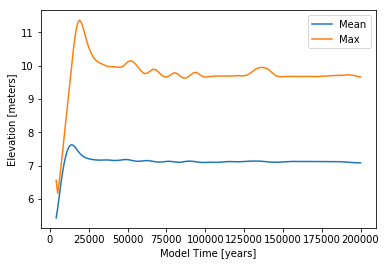

In [11]:
output_files = glob.glob('time_averaged_elevation.*.txt')
temp = {}
for of in output_files:
    with open(of, 'r') as f:
        model_time = int(of.split('.')[-2])
        mean_elev = float(f.readline())
        max_elev = float(f.readline())
        temp[model_time] = {'mean_elevation': mean_elev, 
                            "max_elevation": max_elev}
    os.remove(of)
df = pd.DataFrame(temp).T

basic.remove_output_netcdfs()
output_files = glob.glob('drainage_density.*.txt')
for of in output_files:
    os.remove(of)
    
plt.figure()
plt.plot(df.index, df.mean_elevation, label='Mean')
plt.plot(df.index, df.max_elevation, label='Max')
plt.legend()
plt.xlabel('Model Time [years]')
plt.ylabel('Elevation [meters]')
plt.show()

## Next Steps

- We recommend you review the [terrainbento manuscript](). 
- There are two additional introductory tutorials: [Introduction to terrainbento]() and [Introduction to boundary conditions in terrainbento]().
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:
    - [**Basic**]()
    - [**BasicVm**]()
    - [**BasicCh**]()
    - [**BasicVs**]()
    - [**BasicRT**]()